In [ ]:
!pip install scikeras
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score,precision_score,recall_score
import plotly.express as px

In [ ]:
data = pd.read_csv("/content/final_dataset_with_et.csv")

In [ ]:
data.fillna(method='ffill', inplace=True)  # Forward fill for NaN values
data.fillna(method='bfill', inplace=True)  # Backward fill if any NaN remains
data = data[data['Gs'] > 0]
data['NETRAD'] = data['NETRAD'].replace(-9999, np.nan)
data['NETRAD'].fillna(method='ffill', inplace=True)
data['NETRAD'].fillna(method='bfill', inplace=True)
data = data.dropna()
if data.isnull().any().any():
    print("Warning: Missing values still exist.")
else:
    print("No missing values detected.")

No missing values detected.


<ipython-input-4-1e46e8ee5448>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)  # Forward fill for NaN values
<ipython-input-4-1e46e8ee5448>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)  # Backward fill if any NaN remains
<ipython-input-4-1e46e8ee5448>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['NETRAD'] = data['NETRAD'].replace(-9999, np.nan)
<ipython-input-4-1e46e8ee5448>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chaine

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import plotly.express as px

# Define input combinations
input_combinations = [
     ['TA_F', 'P_F', 'SW_IN_F', 'VPD_F'],                    # Combination 1
     ['TA_F', 'P_F', 'SW_IN_F', 'VPD_F', 'NDVI'],            # Combination 2
    ['TA_F', 'P_F', 'SW_IN_F', 'VPD_F', 'NDVI', 'NIRv']    # Combination 3
]

# Filter data
data = data[data['Gs'] > 0]

# Initialize result storage
aic_results = {}

# Iterate over input combinations
for i, features in enumerate(input_combinations):
    print(f"\nTraining with input combination {i+1}: {features}")

    # Prepare features and target
    X = data[features]
    y = np.log(data['Gs'])  # Log-transform the target

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Check for NaNs in features
    if np.isnan(X_train).any() or np.isnan(X_test).any():
        print("NaN values found in input features. Skipping this combination.")
        continue

    # Define model configurations
    layer_configurations = [
          [64], [128], [128, 64], [64, 64, 32],
        [64, 32]

    ]

    # Iterate over layer configurations
    aic_values = []
    for layers_units in layer_configurations:
        # Build model
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        for units in layers_units:
            model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
        model.add(layers.Dense(1))  # Output layer

        # Compile and train with early stopping
        model.compile(optimizer='Nadam', loss='mean_squared_error')
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0, callbacks=[early_stopping])

        # Predict and calculate evaluation metrics
        predictions = model.predict(X_test).flatten()

        if np.isnan(predictions).any():
            print("NaN values found in predictions. Skipping this model.")
            continue

        # Calculate metrics
        mse = mean_squared_error(y_test, predictions)
        q = np.sum([np.prod(v.shape) for v in model.trainable_variables])
        n = len(y_test)
        aic = np.log(mse) + (2 * q) / n
        aic_values.append((aic, layers_units, mse, np.sqrt(mse), mean_absolute_error(y_test, predictions), r2_score(y_test, predictions)))

        print(f'  Model {layers_units}: MSE: {mse:.4f}, RMSE: {np.sqrt(mse):.4f}, MAE: {mean_absolute_error(y_test, predictions):.4f}, R²: {r2_score(y_test, predictions):.4f}, AIC: {aic:.4f}')

    # Store results for this combination
    if aic_values:
        best_model_info = min(aic_values, key=lambda x: x[0])  # Select model with the lowest AIC
        aic_results[f'Combination {i+1}'] = best_model_info
        print(f'  Best model for combination {i+1}: Layers {best_model_info[1]} with AIC: {best_model_info[0]:.4f}')

# Select the overall best combination and model configuration
if aic_results:
    best_combination = min(aic_results, key=lambda k: aic_results[k][0])
    best_layers = aic_results[best_combination][1]
    best_aic = aic_results[best_combination][0]
    print(f'\nOverall best model is {best_combination} with layers {best_layers} and AIC: {best_aic:.4f}')
else:
    print("No valid models were found due to NaN predictions.")

# Plot the best model's predictions
if aic_results:
    plot_data = pd.DataFrame({
        'Actual Gs': np.exp(y_test),  # Convert back from log scale
        'Predicted Gs': np.exp(predictions)  # Convert back from log scale
    })

    fig = px.scatter(plot_data, x='Actual Gs', y='Predicted Gs', title='Predicted Gs vs Actual Gs',
                     labels={'Actual Gs': 'Actual Gs (original scale)', 'Predicted Gs': 'Predicted Gs (original scale)'},
                     trendline='ols')
    fig.add_trace(px.line(x=plot_data['Actual Gs'], y=plot_data['Actual Gs']).data[0])  # Add perfect fit line
    fig.show()



Training with input combination 1: ['TA_F', 'P_F', 'SW_IN_F', 'VPD_F']
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
  Model [64]: MSE: 0.3291, RMSE: 0.5737, MAE: 0.3376, R²: 0.8570, AIC: 0.4763
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Model [128]: MSE: 0.3423, RMSE: 0.5851, MAE: 0.3131, R²: 0.8513, AIC: 2.0992
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Model [128, 64]: MSE: 0.3297, RMSE: 0.5742, MAE: 0.3474, R²: 0.8568, AIC: 35.8430
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
  Model [64, 64, 32]: MSE: 0.3343, RMSE: 0.5782, MAE: 0.3411, R²: 0.8548, AIC: 26.0919
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Model [64, 32]: MSE: 0.3255, RMSE: 0.5705, MAE: 0.3065, R²: 0.8586, AIC: 8.9107
  Best model for combination 1: Layers [64] with AIC: 0.4763

Training with input combination 2: ['TA_F', 'P_F', 'SW_IN_F', 'VPD_F', 'NDVI']
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Model [64]: MSE: 0.2575, RMSE: 0.5074, MAE: 0.2657, R²: 0.8881, AIC: 0.4947
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Model [128]: MSE: 0.2

In [ ]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize CatBoost model with best parameters
best_catboost_model = CatBoostRegressor(depth=4,
                                        iterations=100,
                                        learning_rate=0.1,
                                        l2_leaf_reg=1,
                                        subsample=1.0,
                                        random_state=42,
                                        verbose=0)

# Fit the model
best_catboost_model.fit(X_train, y_train)

# Predict with the trained model
catboost_predictions = best_catboost_model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, catboost_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, catboost_predictions)
r2 = r2_score(y_test, catboost_predictions)

# Print metrics
print("Best Parameters:")
print(f"  depth: 4, iterations: 100, learning_rate: 0.1, l2_leaf_reg: 1, subsample: 1.0")
print(f'Tuned CatBoost Model Metrics:')
print(f'  MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')

Best Parameters:
  depth: 4, iterations: 100, learning_rate: 0.1, l2_leaf_reg: 1, subsample: 1.0
Tuned CatBoost Model Metrics:
  MSE: 0.1562, RMSE: 0.3953, MAE: 0.2012, R²: 0.9325


In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers

# Define the function for the ANN model with L2 regularization
def create_best_ann_model():
    model = Sequential()
    # Add input layer with L2 regularization
    model.add(Dense(units=best_layers[0], input_dim=X_train.shape[1], activation='relu',
                    kernel_regularizer=regularizers.l2(0.02)))

    # Add hidden layers with L2 regularization
    for units in best_layers[1:]:
        model.add(Dense(units=units, activation='relu',
                        kernel_regularizer=regularizers.l2(0.02)))

    # Add output layer without regularization (typical for regression output)
    model.add(Dense(units=1))

    # Compile the model
    model.compile(optimizer='Nadam', loss='mean_squared_error')
    return model

# Create a KerasRegressor
wrapped_ann_model = KerasRegressor(build_fn=create_best_ann_model, epochs=100, batch_size=16, verbose=0)

# Create a StackingRegressor
stacking_regressor = StackingRegressor(
    estimators=[('ann', wrapped_ann_model), ('catboost', best_catboost_model)],  # Ensure best_catboost_model is defined
    final_estimator=LinearRegression()
)

# Fit the stacking model
stacking_regressor.fit(X_train, y_train)

# Predict and evaluate
stacking_predictions = stacking_regressor.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, stacking_predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, stacking_predictions)
r2 = r2_score(y_test, stacking_predictions)

print("\nStacked Ensemble Model Metrics:")
print(f'  MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}')


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:9


Stacked Ensemble Model Metrics:
  MSE: 0.1531, RMSE: 0.3912, MAE: 0.2021, R²: 0.9338


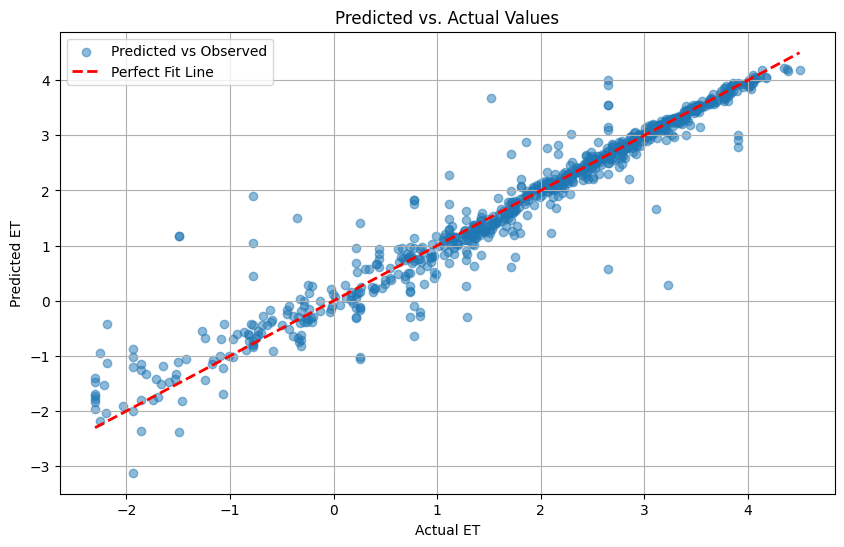

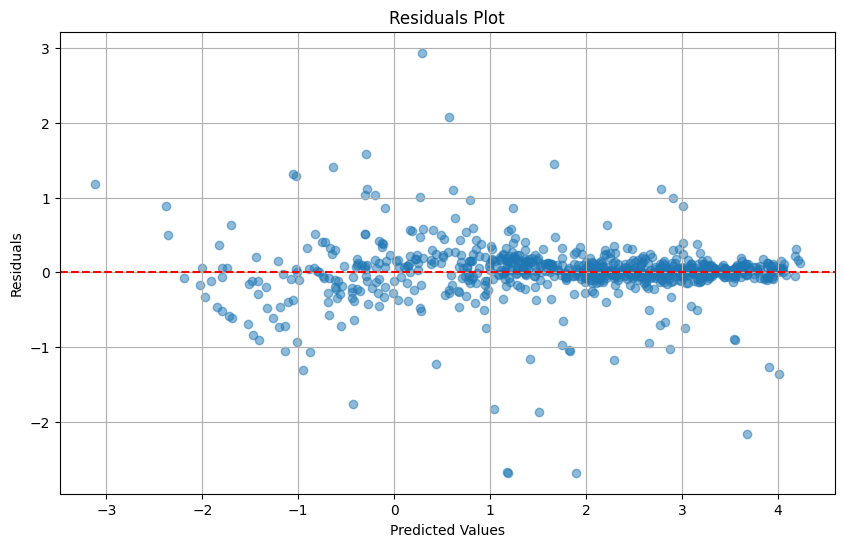

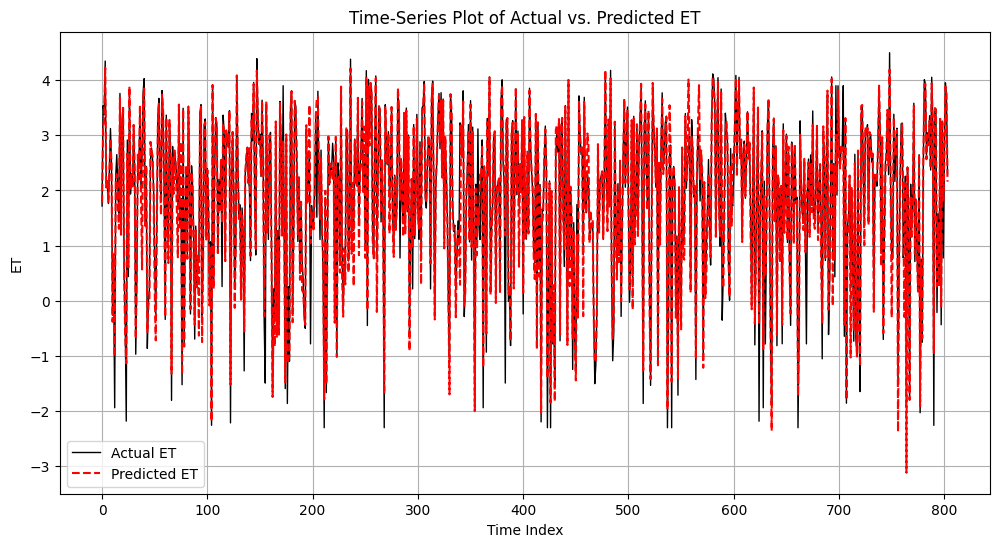

In [ ]:
import matplotlib.pyplot as plt

# 1. Scatter Plot of Predicted vs. Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, stacking_predictions, alpha=0.5, label='Predicted vs Observed')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit Line')
plt.title('Predicted vs. Actual Values')
plt.xlabel('Actual ET')
plt.ylabel('Predicted ET')
plt.legend()
plt.grid(True)
plt.show()

# 2. Residuals Plot
residuals = y_test - stacking_predictions
plt.figure(figsize=(10, 6))
plt.scatter(stacking_predictions, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# 3. Time-Series Plot of Predictions
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, label='Actual ET', color='black', linewidth=1)
plt.plot(range(len(stacking_predictions)), stacking_predictions, label='Predicted ET', color='red', linestyle='--')
plt.title('Time-Series Plot of Actual vs. Predicted ET')
plt.xlabel('Time Index')
plt.ylabel('ET')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Initialize result storage
aic_results = {}
training_history = {}  # Store loss and R² history for each model

# Iterate over input combinations
for i, features in enumerate(input_combinations):
    print(f"\nTraining with input combination {i+1}: {features}")

    # Prepare features and target
    X = data[features]
    y = np.log(data['Gs'])  # Log-transform the target

    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Check for NaNs in features
    if np.isnan(X_train).any() or np.isnan(X_test).any():
        print("NaN values found in input features. Skipping this combination.")
        continue

    # Define model configurations
    layer_configurations = [
        [64], [128], [128, 64], [64, 64, 32], [64, 32]
    ]

    # Iterate over layer configurations
    aic_values = []
    for layers_units in layer_configurations:
        # Build model
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        for units in layers_units:
            model.add(layers.Dense(units, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
        model.add(layers.Dense(1))  # Output layer

        # Compile and train with early stopping
        model.compile(optimizer='Nadam', loss='mean_squared_error')
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=0, callbacks=[early_stopping])

        # Predict and calculate evaluation metrics
        predictions = model.predict(X_test).flatten()

        if np.isnan(predictions).any():
            print("NaN values found in predictions. Skipping this model.")
            continue

        # Calculate metrics
        mse = mean_squared_error(y_test, predictions)
        q = np.sum([np.prod(v.shape) for v in model.trainable_variables])
        n = len(y_test)
        aic = np.log(mse) + (2 * q) / n
        r2 = r2_score(y_test, predictions)

        aic_values.append((aic, layers_units, mse, np.sqrt(mse), mean_absolute_error(y_test, predictions), r2))
        training_history[f'Combination {i+1}, Layers {layers_units}'] = {
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss'],
            'r2': r2
        }

        print(f'  Model {layers_units}: MSE: {mse:.4f}, RMSE: {np.sqrt(mse):.4f}, MAE: {mean_absolute_error(y_test, predictions):.4f}, R²: {r2:.4f}, AIC: {aic:.4f}')

    # Store results for this combination
    if aic_values:
        best_model_info = min(aic_values, key=lambda x: x[0])  # Select model with the lowest AIC
        aic_results[f'Combination {i+1}'] = best_model_info
        print(f'  Best model for combination {i+1}: Layers {best_model_info[1]} with AIC: {best_model_info[0]:.4f}')



Training with input combination 1: ['TA_F', 'P_F', 'SW_IN_F', 'VPD_F']
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Model [64]: MSE: 0.3276, RMSE: 0.5724, MAE: 0.3211, R²: 0.8577, AIC: 0.4717
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Model [128]: MSE: 0.3276, RMSE: 0.5723, MAE: 0.3294, R²: 0.8577, AIC: 2.0551
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Model [128, 64]: MSE: 0.3412, RMSE: 0.5841, MAE: 0.3433, R²: 0.8517, AIC: 35.8774
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Model [64, 64, 32]: MSE: 0.3343, RMSE: 0.5782, MAE: 0.3315, R²: 0.8548, AIC: 26.0918
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
  Model [64, 32]: MSE: 0.3243, RMSE: 0.5695, MAE: 0.3279, R²: 0.8591, AIC: 8.9069
  Best model for combination 1: Layers [64] with AIC: 0.4717

Training with input combination 2: ['TA_F', 'P_F', 'SW_IN_F', 'VPD_F', 'NDVI']
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Model [64]: MSE: 0.2617, RMSE: 0.5116, MAE: 0.2411, R²: 0.8863, AIC: 0.5110
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
  Model [128]: MSE: 0.

Generating plots for Combination 1...


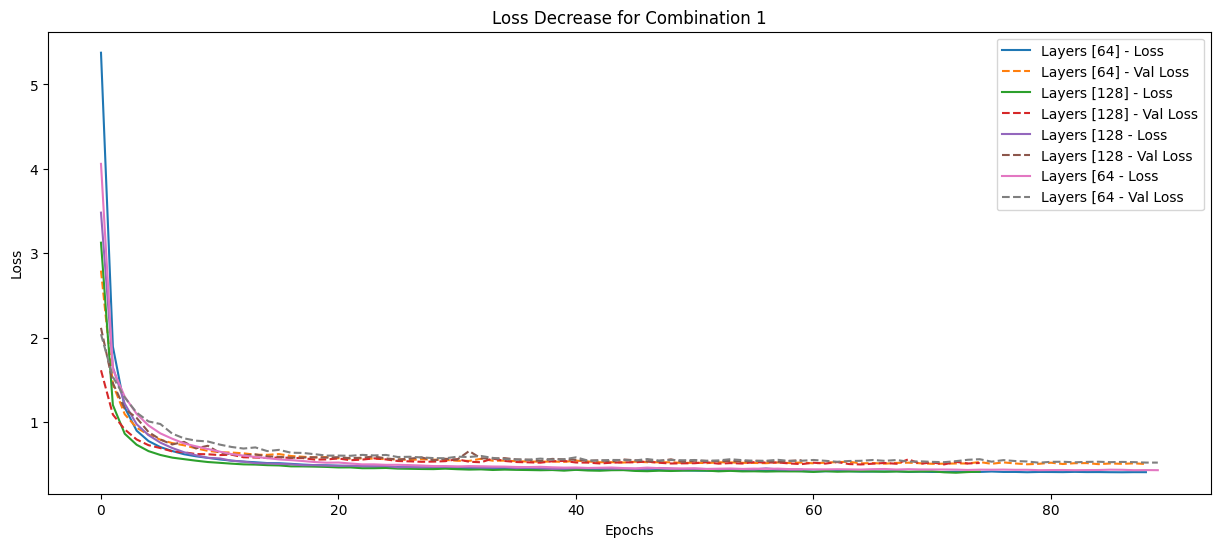

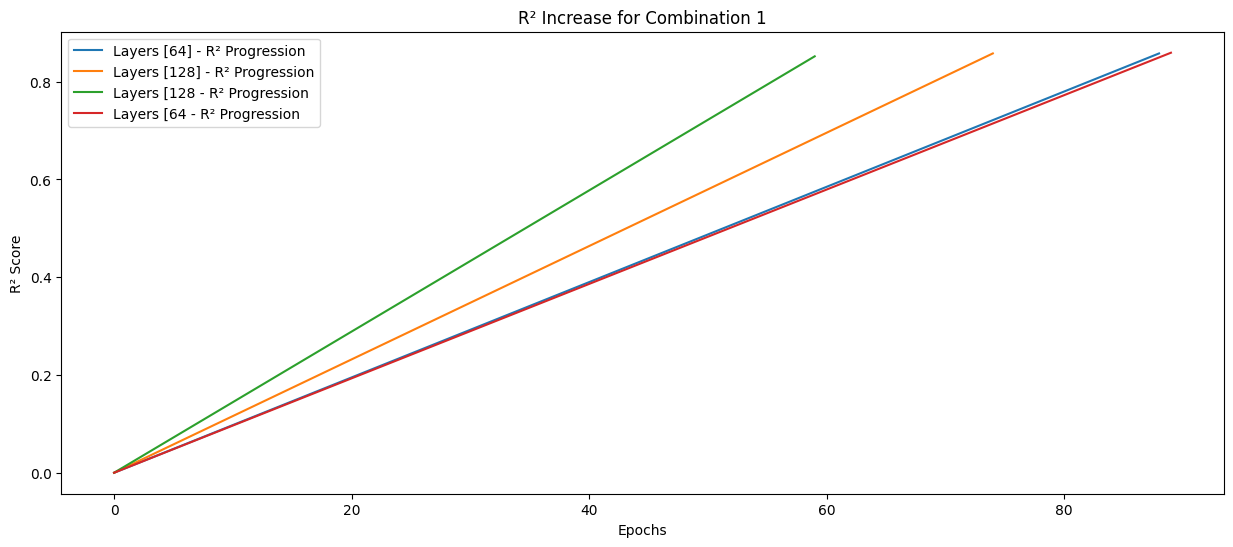

Generating plots for Combination 2...


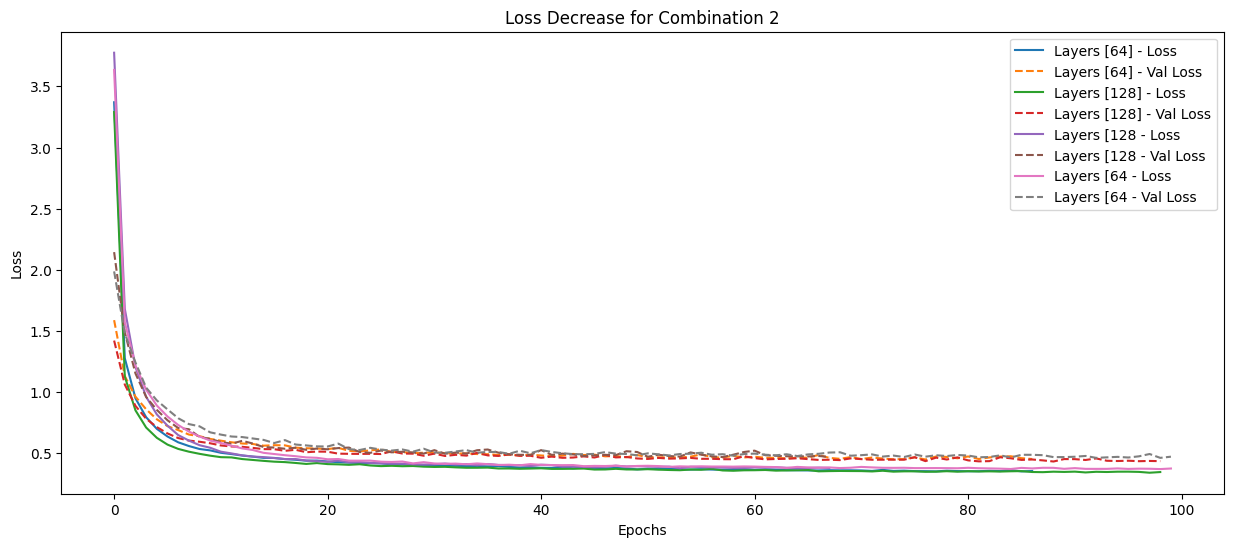

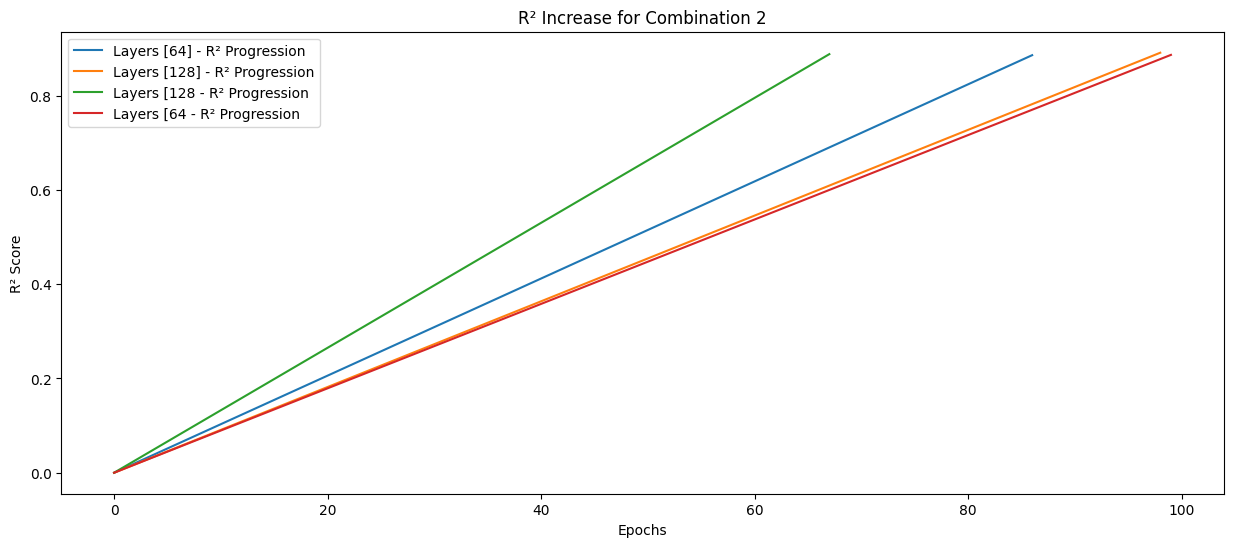

Generating plots for Combination 3...


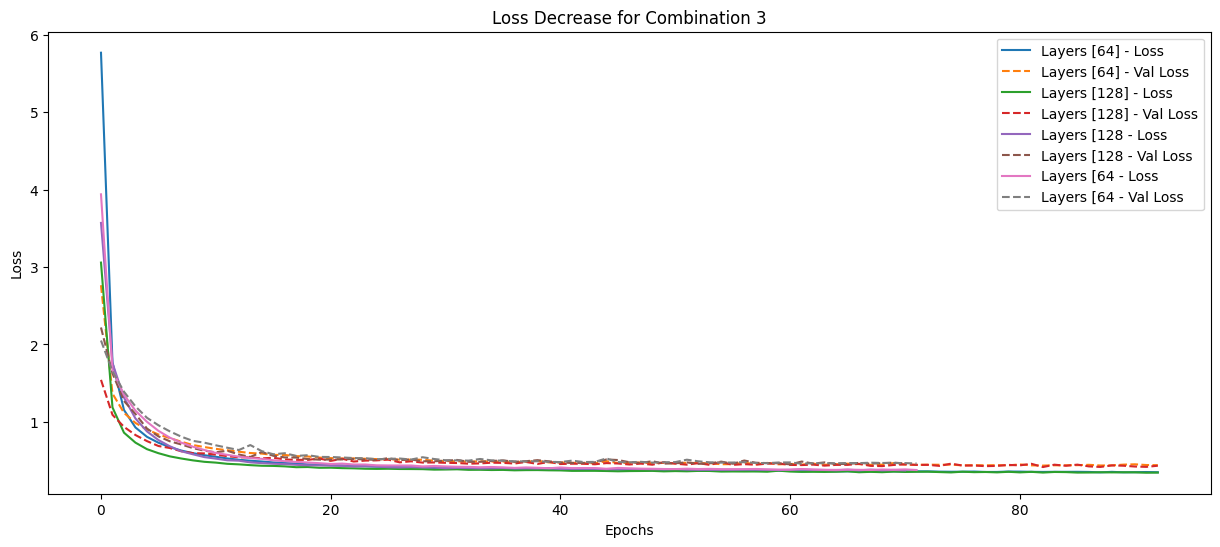

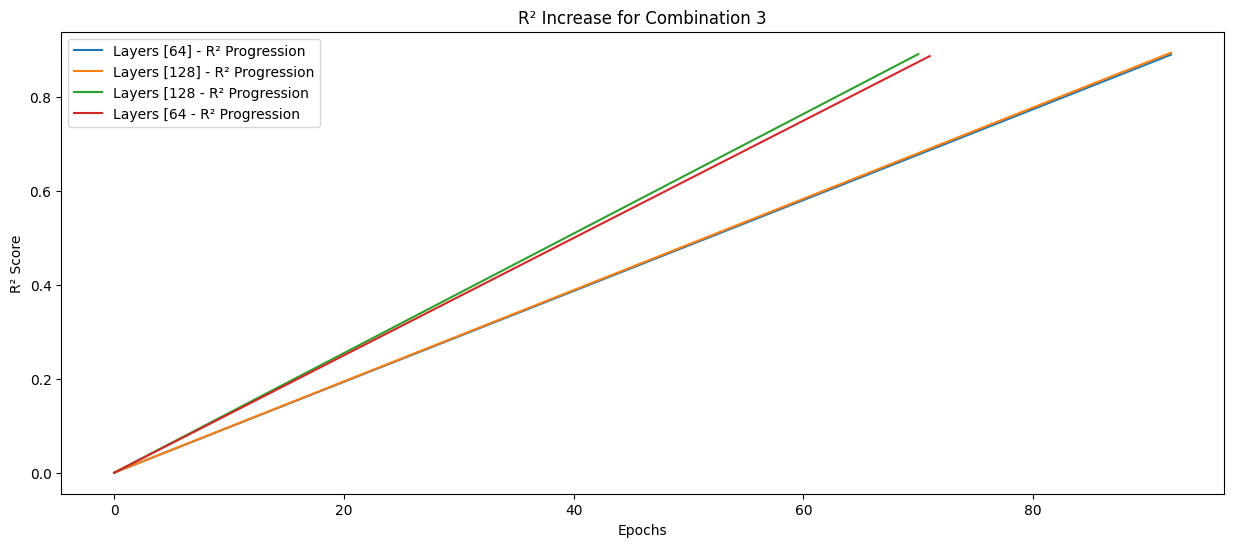

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Group histories by combinations and layer configurations
combinations_histories = {}
for model_name, history in training_history.items():
    parts = model_name.split(',')
    combination = parts[0]  # Extract the combination
    layers = parts[1].strip()  # Extract the layer configuration
    if combination not in combinations_histories:
        combinations_histories[combination] = {}
    combinations_histories[combination][layers] = history

# Plot for each combination and layer configuration
for combination, layers_histories in combinations_histories.items():
    print(f"Generating plots for {combination}...")

    # Plot loss for all layers in this combination
    plt.figure(figsize=(15, 6))
    for layers, history in layers_histories.items():
        plt.plot(history['loss'], label=f"{layers} - Loss")
        plt.plot(history['val_loss'], '--', label=f"{layers} - Val Loss")

    plt.title(f"Loss Decrease for {combination}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Plot R² increase for all layers in this combination
    plt.figure(figsize=(15, 6))
    for layers, history in layers_histories.items():
        # Simulate R² progression if not stored
        epochs = len(history['val_loss'])
        if 'r2_progression' not in history:
            history['r2_progression'] = np.linspace(0, history['r2'], epochs)

        plt.plot(history['r2_progression'], label=f"{layers} - R² Progression")

    plt.title(f"R² Increase for {combination}")
    plt.xlabel("Epochs")
    plt.ylabel("R² Score")
    plt.legend()
    plt.show()



